In [84]:
import torch

from data import dinoSketchSet
from utils import rasterize_strokes_vectorized

from transformers import CLIPProcessor, CLIPVisionModel

import os

import matplotlib.pyplot as plt

In [85]:
device = "cuda"
dpi = 300

In [86]:
clip = CLIPVisionModel.from_pretrained(
    "openai/clip-vit-base-patch16",
    #attn_implementation="flash_attention_2",
    device_map=device,
    #torch_dtype=torch.float,
)

processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# Setup DINO with hooks
activations = {}
def get_activation(name):
    def hook(model, input, output):
        # Store the patch tokens, excluding CLS token
        activations[name] = output[:, 1:, :]
    return hook

dino = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14').to(device = device)

# Register hooks for each block
for i, block in enumerate(dino.blocks):
    block.register_forward_hook(get_activation(f'block_{i}'))


Using cache found in /home/s6toweis_hpc/.cache/torch/hub/facebookresearch_dinov2_main


In [87]:
root_dir = os.path.expanduser("~/data/fscoco-clone/")
dataset = dinoSketchSet(root_dir)

000000000025
000000000049
000000000072
000000000081
000000000322
000000001739
000000000025
000000000049
000000000072
000000000081
000000000322
000000001739
000000000025
000000000049
000000000072
000000000081
000000000322
000000001739


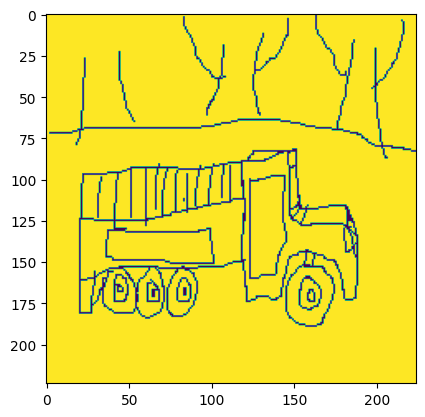

In [88]:
indices = [0, 2, 3, 4, 12, 42]
vector_sketches = [dataset[i][0] for i in indices]
rasterized_strokes = [dataset[i][1] for i in indices]
rasterized_sketches = [dataset[i][2] for i in indices]

plt.imshow(rasterized_sketches[5])

In [89]:
prepared_images = processor(images = torch.stack(rasterized_sketches).unsqueeze(1).repeat(1, 3, 1, 1), do_rescale = False, return_tensors="pt")["pixel_values"]

clip_features = torch.stack(clip(prepared_images.to(device = device), output_hidden_states = True)["hidden_states"], 1)[:, :, 1:]
print(clip_features.shape)

dino_features = dino.forward_features(prepared_images.to(device = device))['x_norm_patchtokens']
#print([(x, dino_features[x].shape) for x in dino_features if hasattr(dino_features[x], 'shape')])
print(dino_features.shape)

torch.Size([6, 13, 196, 768])
torch.Size([6, 256, 384])


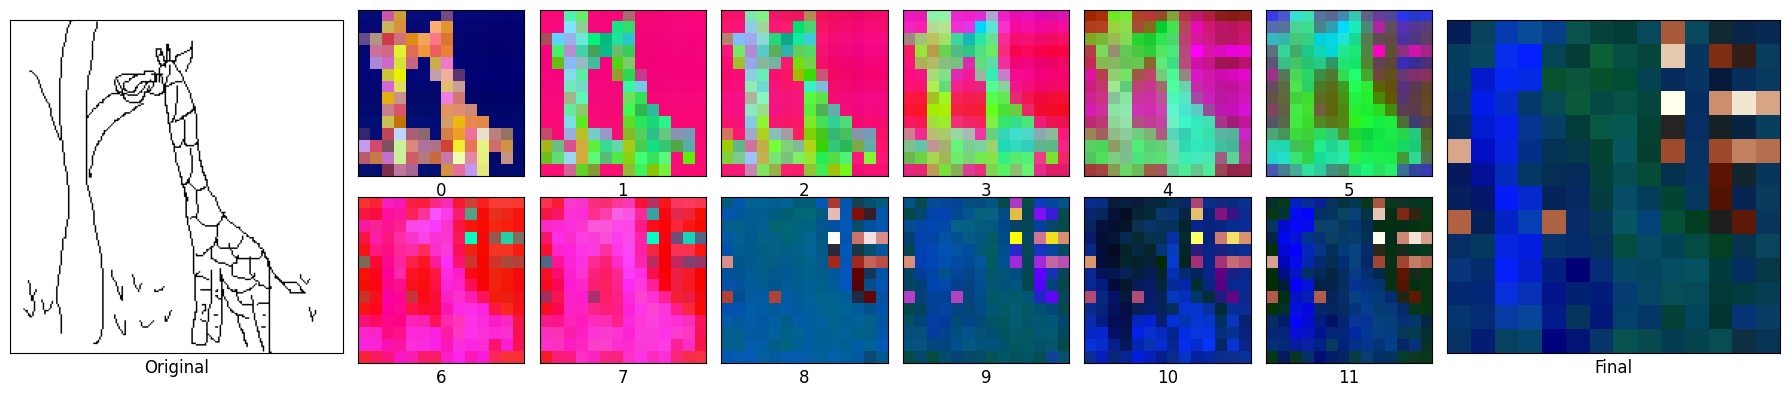

In [90]:
def visualize_feature(feature, axis):
    feature = (feature - torch.min(feature)) / (torch.max(feature) - torch.min(feature))
    axis.imshow(feature.detach().cpu())

U, S, V = torch.svd_lowrank(clip_features, q=3)

U_min, U_max = torch.min(U, dim = 2)[0], torch.max(U, dim = 2)[0]
U = (U - U_min.unsqueeze(2)) / (U_max - U_min).unsqueeze(2)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 8, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2], height_ratios=[1, 1], figure = fig)

#fig, axes = plt.subplots(1, 13, figsize=(10, 10))
ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large = fig.add_subplot(gs[:, 7])
visualize_feature(U[0, -1].reshape(14, 14, 3), ax_large)
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        visualize_feature(U[0, i].reshape(14, 14, 3), ax)
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("clip_svd.pdf", dpi = dpi)

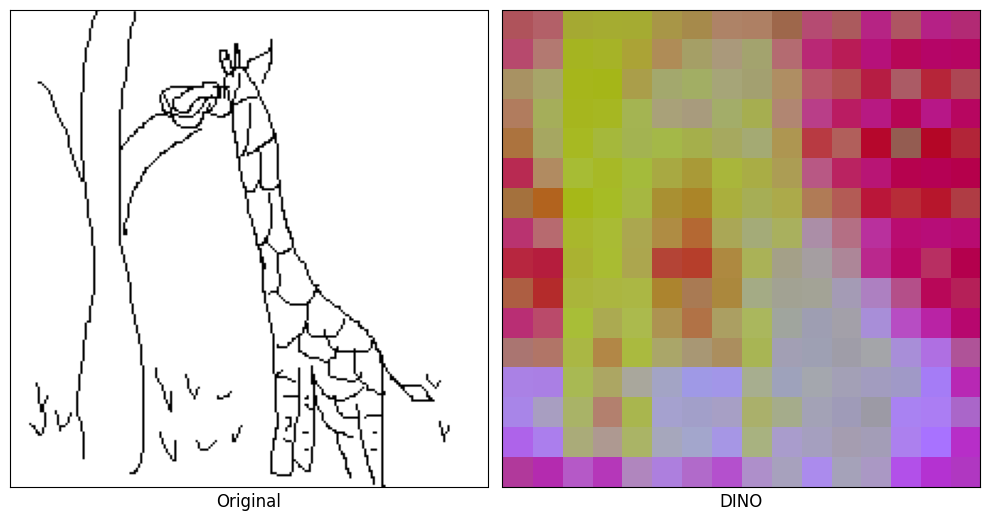

In [91]:
# Visualize dino features:
U, S, V = torch.svd_lowrank(dino_features, q = 3)

fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(rasterized_sketches[0], cmap="gray")
axes[0].set_xlabel("Original", fontsize=12)
axes[0].set_xticks([])
axes[0].set_yticks([])

visualize_feature(U[0].reshape(16, 16, 3), axes[1])
axes[1].set_xlabel("DINO", fontsize=12)
axes[1].set_xticks([])
axes[1].set_yticks([])


plt.tight_layout()

torch.Size([6, 13, 256, 384])


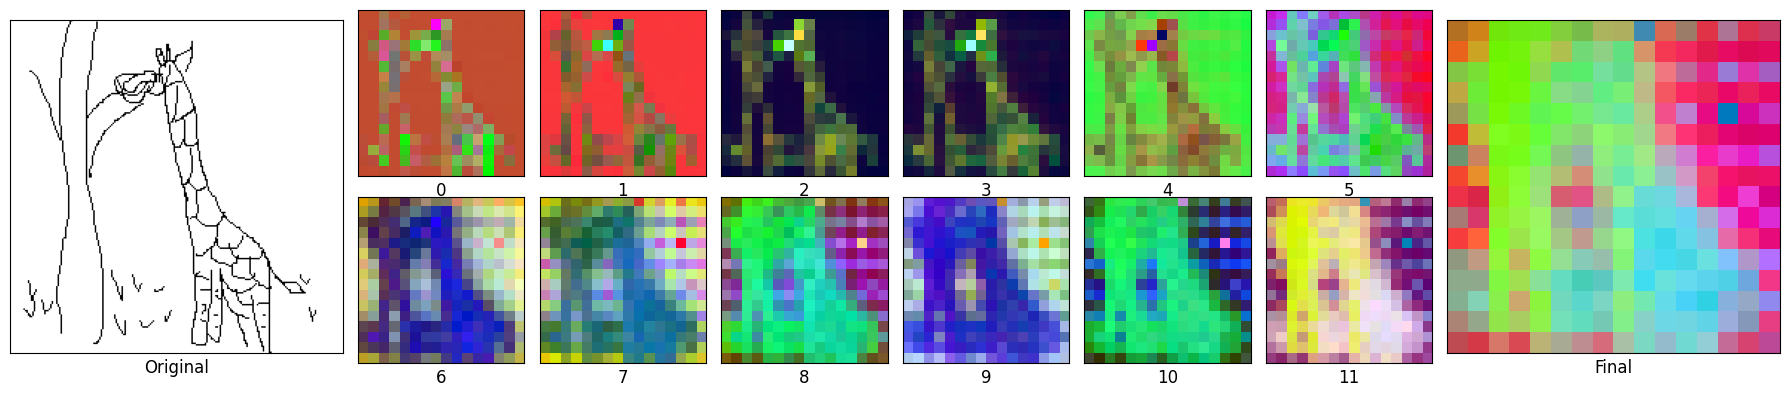

In [92]:
# Forward pass
final_feature = dino.forward_features(prepared_images.to(device=device))["x_norm_patchtokens"]

# Stack features like CLIP format
dino_features_hierarchical = torch.stack([activations[f'block_{i}'] for i in range(len(dino.blocks))] + [final_feature], 1)
print(dino_features_hierarchical.shape)  # Should be [B, L, P, D] where L is number of layers

# Now you can analyze DINO features the same way as CLIP:

# SVD visualization
U, S, V = torch.svd_lowrank(dino_features_hierarchical, q=3)

U_min, U_max = torch.min(U, dim = 2)[0], torch.max(U, dim = 2)[0]
U = (U - U_min.unsqueeze(2)) / (U_max - U_min).unsqueeze(2)

import matplotlib.gridspec as gridspec
fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 8, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2], height_ratios=[1, 1], figure = fig)

#fig, axes = plt.subplots(1, 13, figsize=(10, 10))
ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large = fig.add_subplot(gs[:, 7])
visualize_feature(U[0, -1].reshape(16, 16, 3), ax_large)
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        visualize_feature(U[0, i].reshape(16, 16, 3), ax)
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("dino_svd.pdf", dpi = dpi)

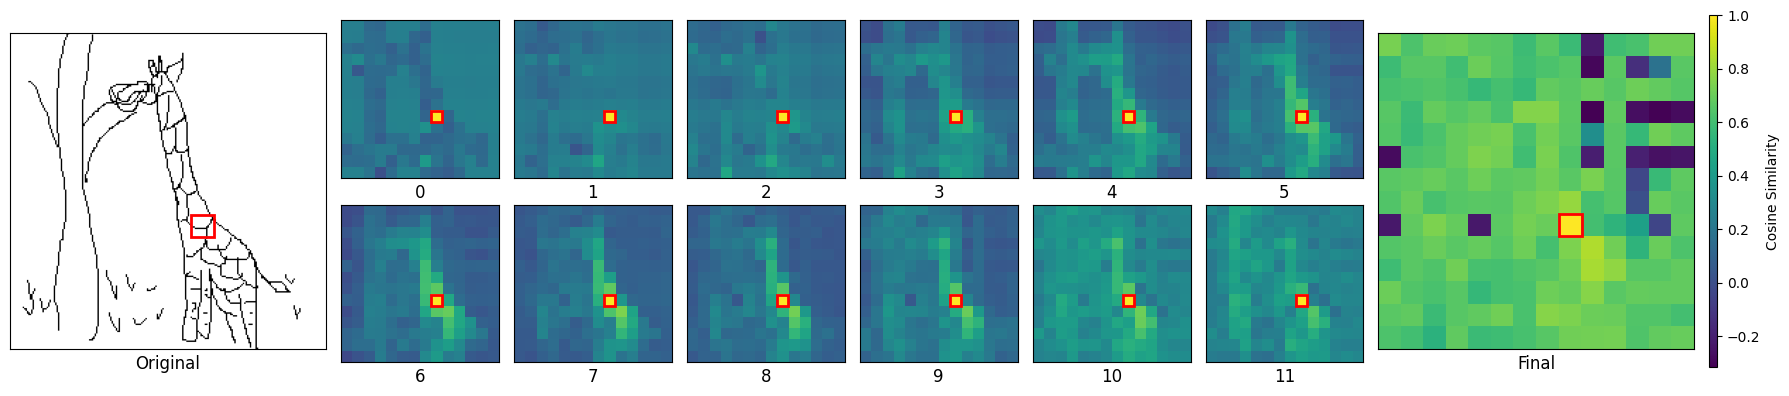

In [93]:
import matplotlib.patches as patches

# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(clip_features, dim = -1)
target_row, target_col = 8, 8
target_feature = normed_features.reshape(6, 13, 14, 14, 768)[0, :, target_row, target_col, :]

x, y = target_col * 16, target_row * 16
width, height = 16, 16

cos_sim = (target_feature.unsqueeze(1) * normed_features[0]).sum(-1)

fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)

ax_large = fig.add_subplot(gs[:, 7])
im = ax_large.imshow(cos_sim[-1].detach().cpu().reshape(14, 14), vmin=vmin, vmax=vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim[i].detach().cpu().reshape(14, 14), vmin=vmin, vmax=vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("clip_cos_sim_good.pdf", dpi = dpi)

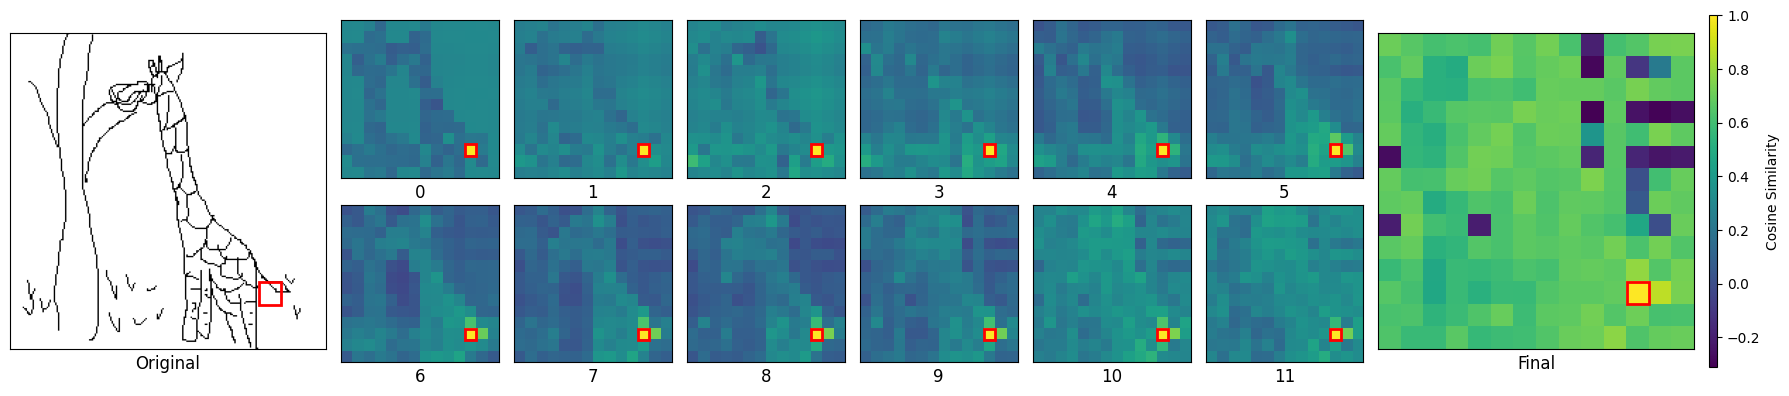

In [94]:
import matplotlib.patches as patches

# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(clip_features, dim = -1)

target_row, target_col = 11, 11
target_feature = normed_features.reshape(6, 13, 14, 14, 768)[0, :, target_row, target_col, :]

x, y = target_col * 16, target_row * 16
width, height = 16, 16

cos_sim = (target_feature.unsqueeze(1) * normed_features[0]).sum(-1)

fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

#fig, axes = plt.subplots(1, 13, figsize=(10, 10))
ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)

ax_large = fig.add_subplot(gs[:, 7])
im = ax_large.imshow(cos_sim[-1].detach().cpu().reshape(14, 14), vmin=vmin, vmax=vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim[i].detach().cpu().reshape(14, 14), vmin=vmin, vmax=vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("clip_cos_sim_bad.pdf", dpi = dpi)

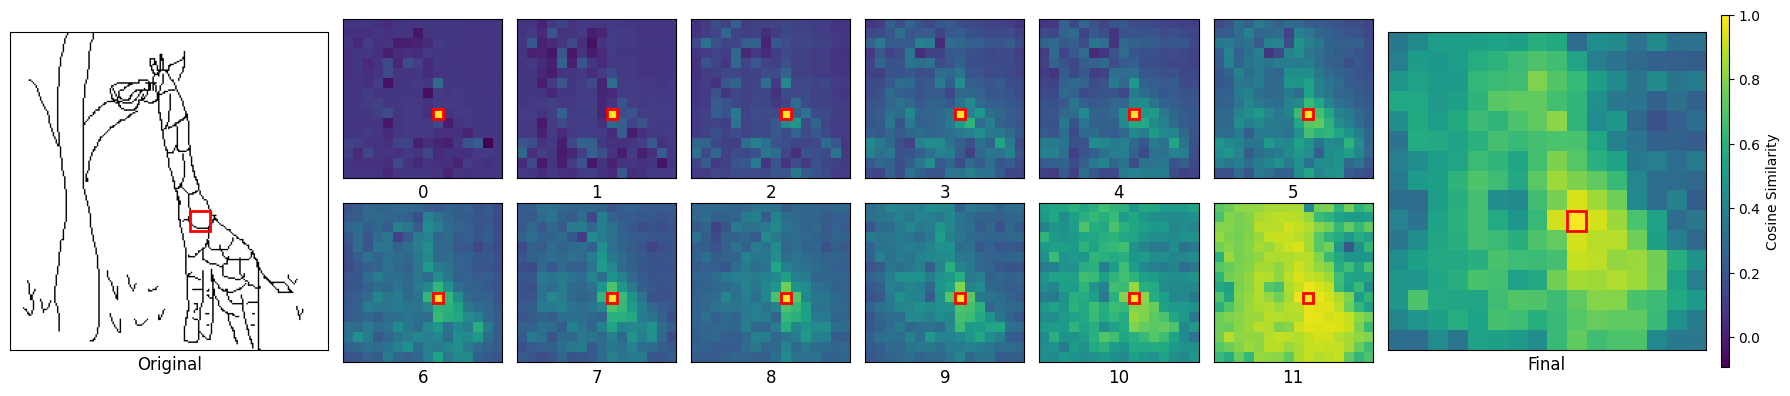

In [95]:
# Similarity visualization
normed_features = torch.nn.functional.normalize(dino_features_hierarchical, dim=-1)
target_row, target_col = 9, 9
target_feature = normed_features.reshape(6, 13, 16, 16, 384)[0, :, target_row, target_col, :]

x, y = target_col * 14, target_row * 14
width, height = 14, 14

cos_sim = (target_feature.unsqueeze(1) * normed_features[0]).sum(-1)

fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

#fig, axes = plt.subplots(1, 13, figsize=(10, 10))
ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)

ax_large = fig.add_subplot(gs[:, 7])
im = ax_large.imshow(cos_sim[-1].detach().cpu().reshape(16, 16), vmin=vmin, vmax=vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim[i].detach().cpu().reshape(16, 16), vmin=vmin, vmax=vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("dino_cos_sim_good.pdf", dpi = dpi)

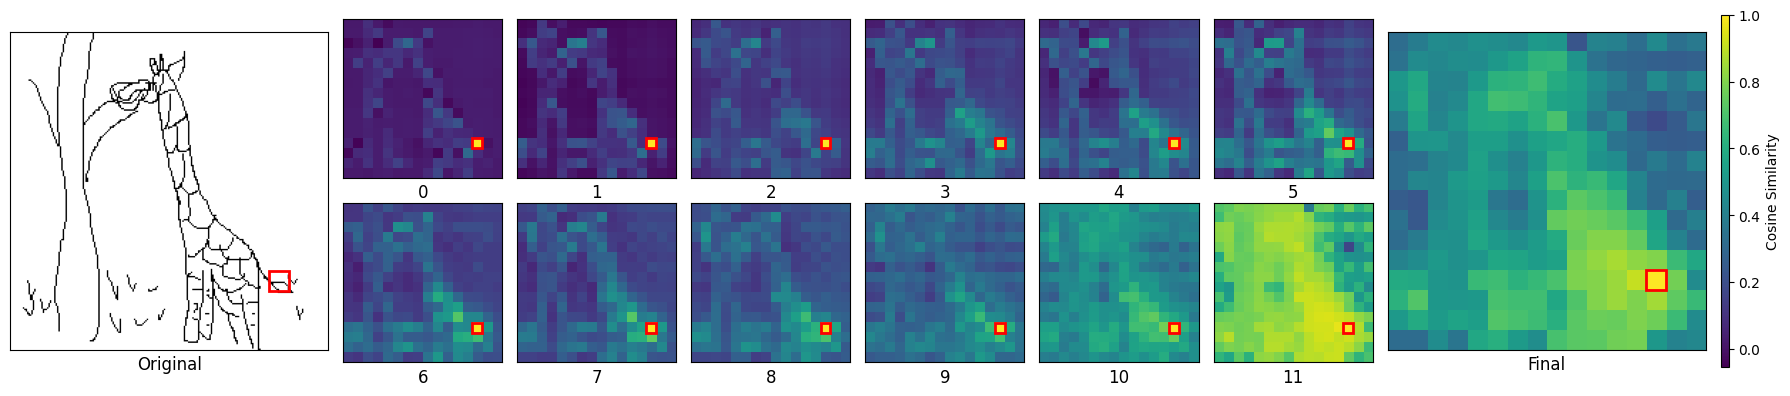

In [96]:
# Similarity visualization
normed_features = torch.nn.functional.normalize(dino_features_hierarchical, dim=-1)
target_row, target_col = 12, 13
target_feature = normed_features.reshape(6, 13, 16, 16, 384)[0, :, target_row, target_col, :]

x, y = target_col * 14, target_row * 14
width, height = 14, 14

cos_sim = (target_feature.unsqueeze(1) * normed_features[0]).sum(-1)

fig = plt.figure(figsize=(18, 4))

gs = gridspec.GridSpec(2, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

#fig, axes = plt.subplots(1, 13, figsize=(10, 10))
ax_large = fig.add_subplot(gs[:, 0])
ax_large.imshow(rasterized_sketches[0], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)

ax_large = fig.add_subplot(gs[:, 7])
im = ax_large.imshow(cos_sim[-1].detach().cpu().reshape(16, 16), vmin=vmin, vmax=vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim[i].detach().cpu().reshape(16, 16), vmin=vmin, vmax=vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("dino_cos_sim_bad.pdf", dpi = dpi)

tensor(-0.2086, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


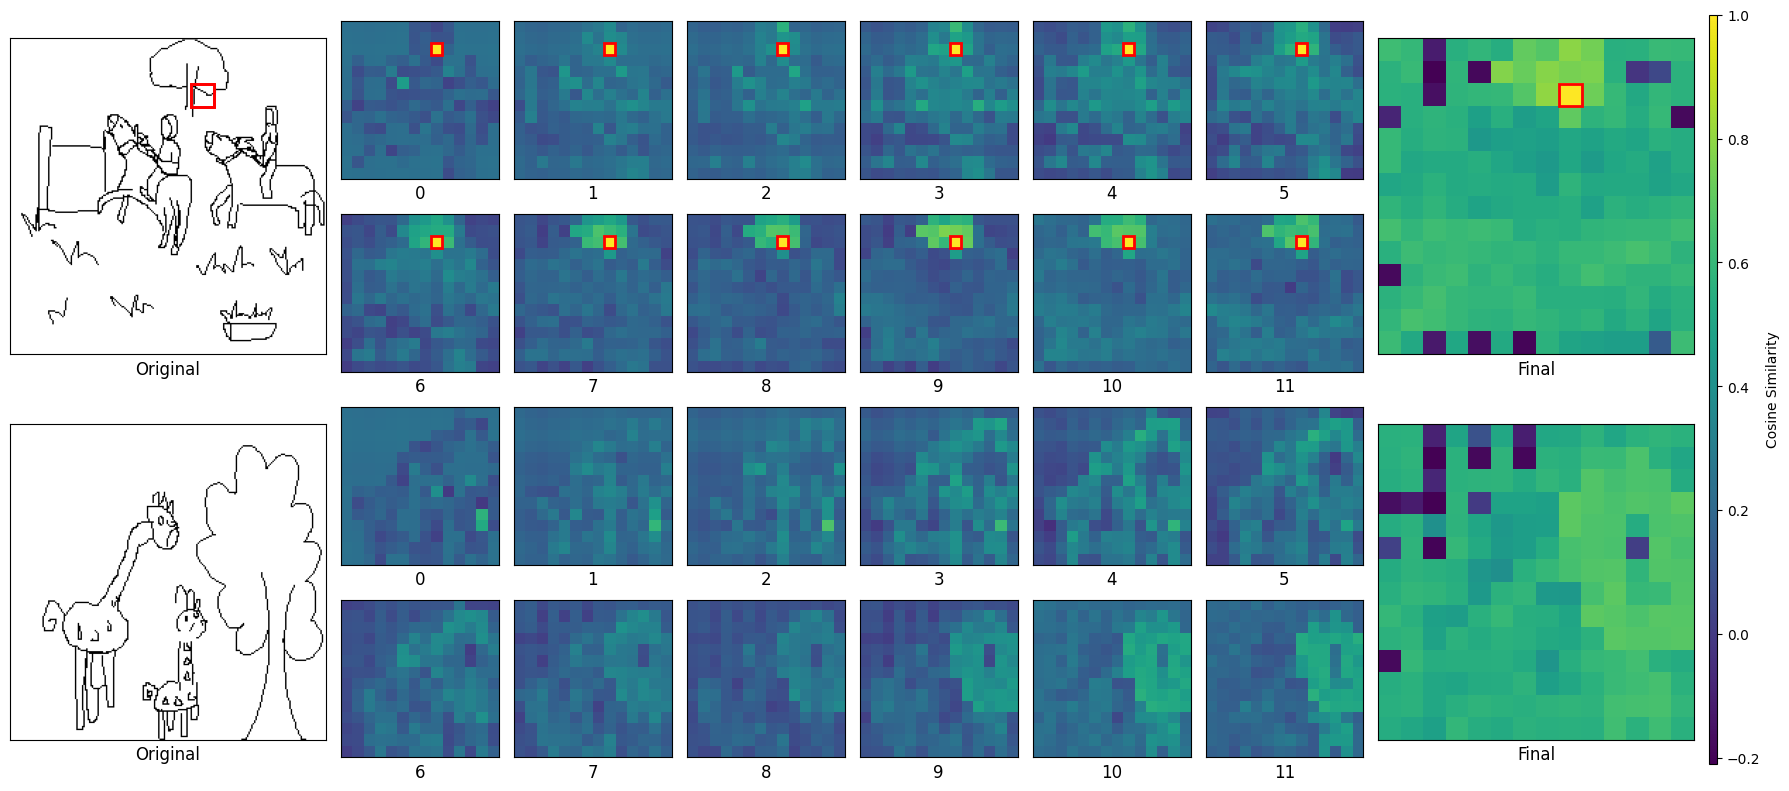

In [97]:
# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(clip_features, dim = -1)

target_row, target_col  = 2, 8
target_feature = normed_features.reshape(6, 13, 14, 14, 768)[1, :, target_row, target_col, :]

x, y = target_col * 16, target_row * 16
width, height = 16, 16

cos_sim1 = (target_feature.unsqueeze(1) * normed_features[1]).sum(-1)
cos_sim2 = (target_feature.unsqueeze(1) * normed_features[2]).sum(-1)
print(torch.min(cos_sim1), torch.max(cos_sim1))
vmin, vmax = torch.min(torch.stack([cos_sim1, cos_sim2])), torch.max(torch.stack([cos_sim1, cos_sim2]))


fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[0:2, 0])
ax_large.imshow(rasterized_sketches[1], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

ax_large1 = fig.add_subplot(gs[0:2, 7])
ax_large1.imshow(cos_sim1[-1].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
ax_large1.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large1.set_xlabel("Final", fontsize=12)
ax_large1.set_xticks([])
ax_large1.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim1[i].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])


ax_large = fig.add_subplot(gs[2:, 0])
ax_large.imshow(rasterized_sketches[2], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large2 = fig.add_subplot(gs[2:, 7])
im = ax_large2.imshow(cos_sim2[-1].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
# ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large2.set_xlabel("Final", fontsize=12)
ax_large2.set_xticks([])
ax_large2.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row+2, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim2[i].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
        # ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("clip_cos_sim_inter.pdf", dpi = dpi)

tensor(-0.2731, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


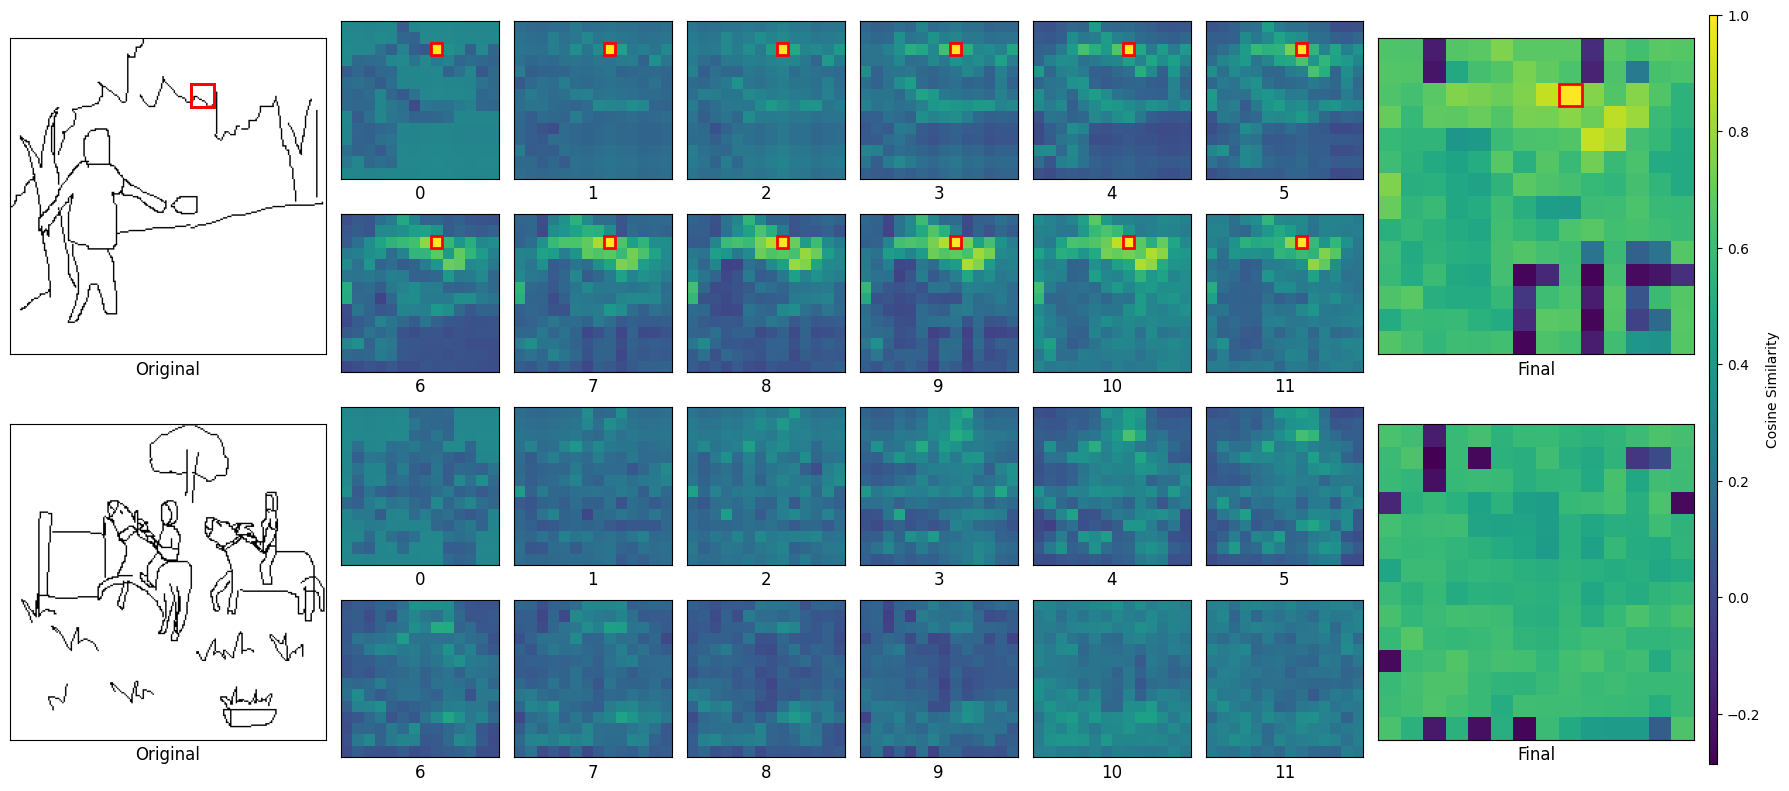

In [98]:
# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(clip_features, dim = -1)

target_row, target_col  = 2, 8
target_feature = normed_features.reshape(6, 13, 14, 14, 768)[4, :, target_row, target_col, :]

x, y = target_col * 16, target_row * 16
width, height = 16, 16

cos_sim1 = (target_feature.unsqueeze(1) * normed_features[4]).sum(-1)
cos_sim2 = (target_feature.unsqueeze(1) * normed_features[1]).sum(-1)
print(torch.min(cos_sim1), torch.max(cos_sim1))
vmin, vmax = torch.min(torch.stack([cos_sim1, cos_sim2])), torch.max(torch.stack([cos_sim1, cos_sim2]))


fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[0:2, 0])
ax_large.imshow(rasterized_sketches[4], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

ax_large1 = fig.add_subplot(gs[0:2, 7])
ax_large1.imshow(cos_sim1[-1].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
ax_large1.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large1.set_xlabel("Final", fontsize=12)
ax_large1.set_xticks([])
ax_large1.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim1[i].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])


ax_large = fig.add_subplot(gs[2:, 0])
ax_large.imshow(rasterized_sketches[1], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large2 = fig.add_subplot(gs[2:, 7])
im = ax_large2.imshow(cos_sim2[-1].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
# ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large2.set_xlabel("Final", fontsize=12)
ax_large2.set_xticks([])
ax_large2.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row+2, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim2[i].detach().cpu().reshape(14, 14), vmin = vmin, vmax = vmax)
        # ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("clip_cos_sim_inter_lim.pdf", dpi = dpi)

tensor(-0.1303, device='cuda:0', grad_fn=<MinBackward1>) tensor(1., device='cuda:0', grad_fn=<MaxBackward1>)


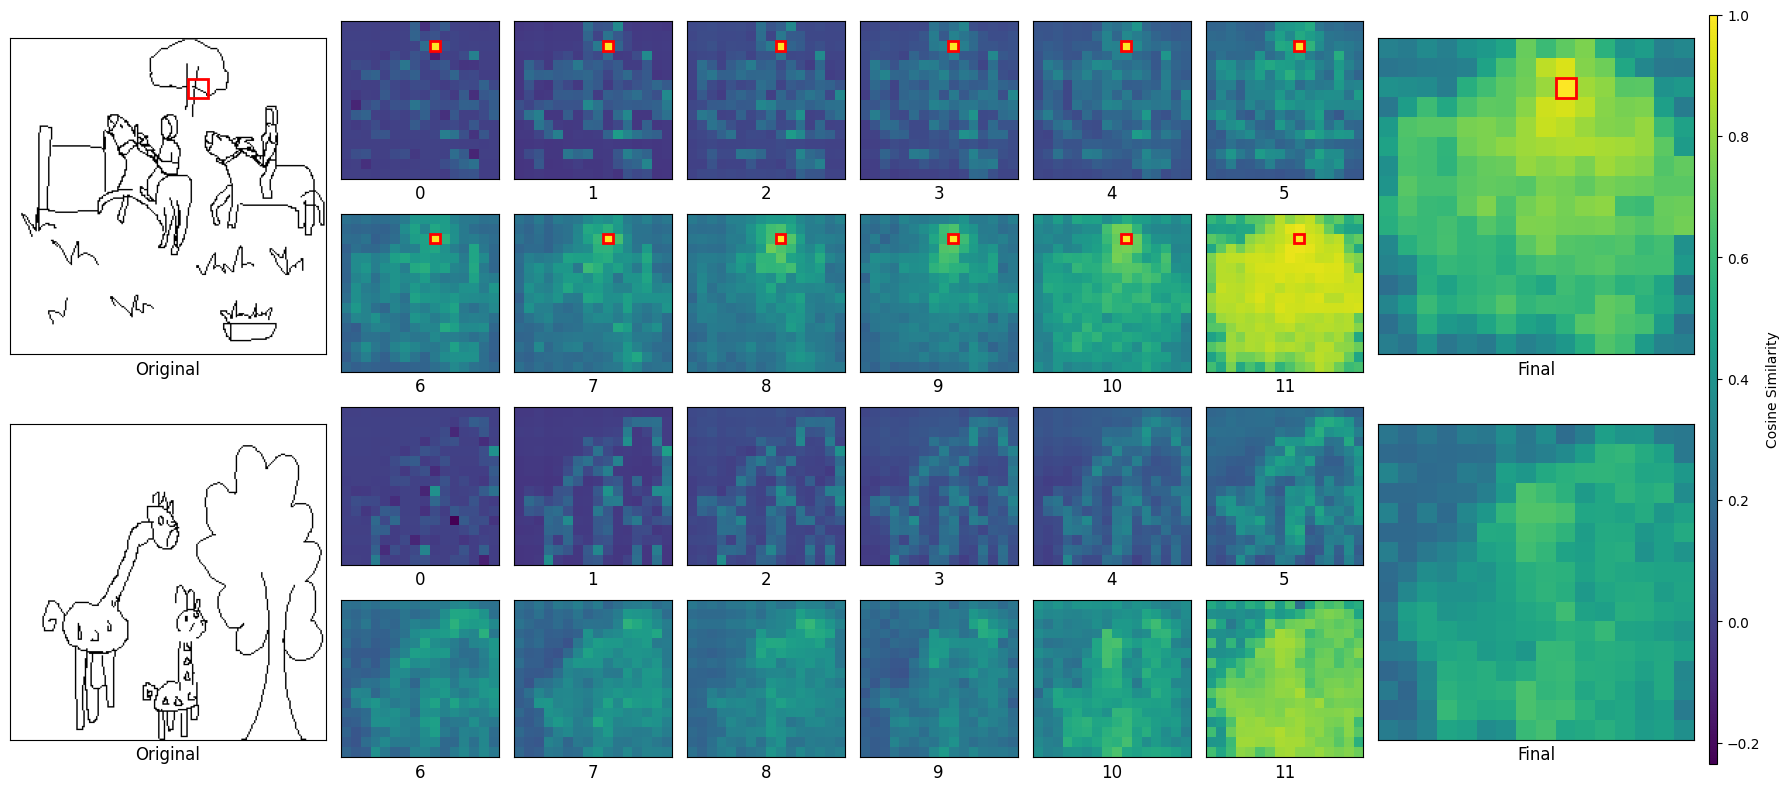

In [99]:
# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(dino_features_hierarchical, dim = -1)

target_row, target_col  = 2, 9
target_feature = normed_features.reshape(6, 13, 16, 16, 384)[1, :, target_row, target_col, :]

x, y = target_col * 14, target_row * 14
width, height = 14, 14

cos_sim1 = (target_feature.unsqueeze(1) * normed_features[1]).sum(-1)
cos_sim2 = (target_feature.unsqueeze(1) * normed_features[2]).sum(-1)
print(torch.min(cos_sim1), torch.max(cos_sim1))
vmin, vmax = torch.min(torch.stack([cos_sim1, cos_sim2])), torch.max(torch.stack([cos_sim1, cos_sim2]))


fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[0:2, 0])
ax_large.imshow(rasterized_sketches[1], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

ax_large = fig.add_subplot(gs[0:2, 7])
ax_large.imshow(cos_sim1[-1].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim1[i].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])


ax_large = fig.add_subplot(gs[2:, 0])
ax_large.imshow(rasterized_sketches[2], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large = fig.add_subplot(gs[2:, 7])
im = ax_large.imshow(cos_sim2[-1].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
# ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row+2, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim2[i].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
        # ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("dino_cos_sim_inter.pdf", dpi = dpi)

tensor(-0.0790, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


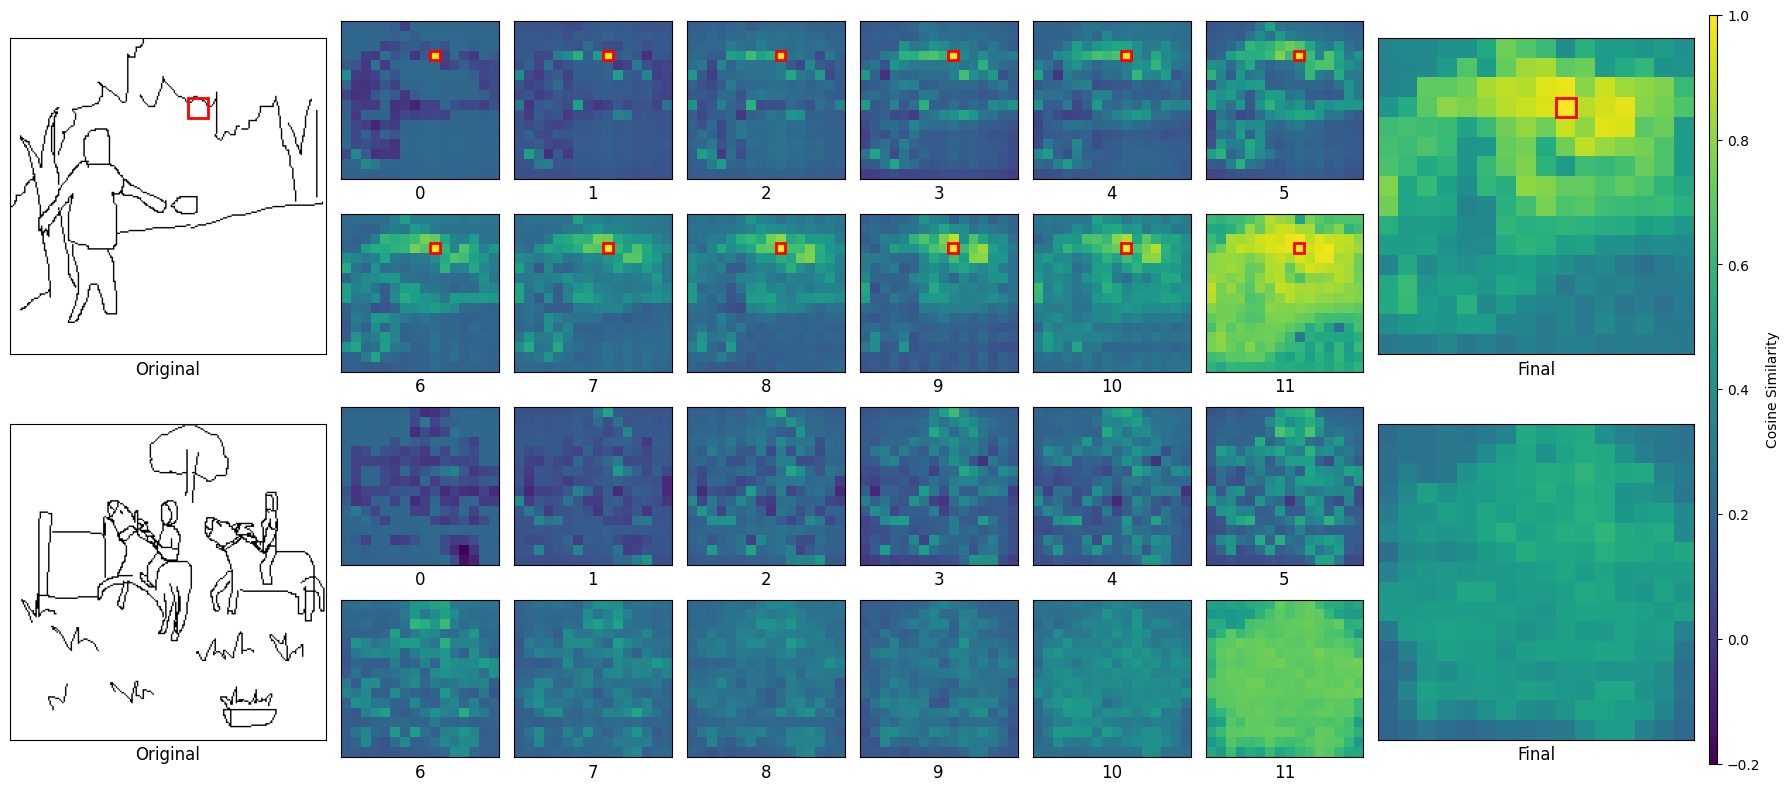

In [111]:
# Visualize patch wise similarity:
normed_features = torch.nn.functional.normalize(dino_features_hierarchical, dim = -1)

target_row, target_col  = 3, 9
target_feature = normed_features.reshape(6, 13, 16, 16, 384)[4, :, target_row, target_col, :]

x, y = target_col * 14, target_row * 14
width, height = 14, 14

cos_sim1 = (target_feature.unsqueeze(1) * normed_features[4]).sum(-1)
cos_sim2 = (target_feature.unsqueeze(1) * normed_features[1]).sum(-1)
print(torch.min(cos_sim1), torch.max(cos_sim1))
vmin, vmax = torch.min(torch.stack([cos_sim1, cos_sim2])), torch.max(torch.stack([cos_sim1, cos_sim2]))


fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 9, width_ratios = [2, 1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[0:2, 0])
ax_large.imshow(rasterized_sketches[4], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

ax_large = fig.add_subplot(gs[0:2, 7])
ax_large.imshow(cos_sim1[-1].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='red', facecolor='none')
ax_large.add_patch(rect)

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim1[i].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
        ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])


ax_large = fig.add_subplot(gs[2:, 0])
ax_large.imshow(rasterized_sketches[1], cmap="gray")
ax_large.set_xlabel("Original", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

ax_large = fig.add_subplot(gs[2:, 7])
im = ax_large.imshow(cos_sim2[-1].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
# ax_large.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row+2, col + 1])
        ax.set_title("")
        i = row * 6 + col
        ax.imshow(cos_sim2[i].detach().cpu().reshape(16, 16), vmin = vmin, vmax = vmax)
        # ax.add_patch(plt.Rectangle((target_col - 0.5, target_row - 0.5), 1, 1, edgecolor='red', facecolor='none', linewidth=2))
        ax.set_xlabel(str(i), fontsize=12)
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.savefig("dino_cos_sim_inter_limit.pdf", dpi = dpi)

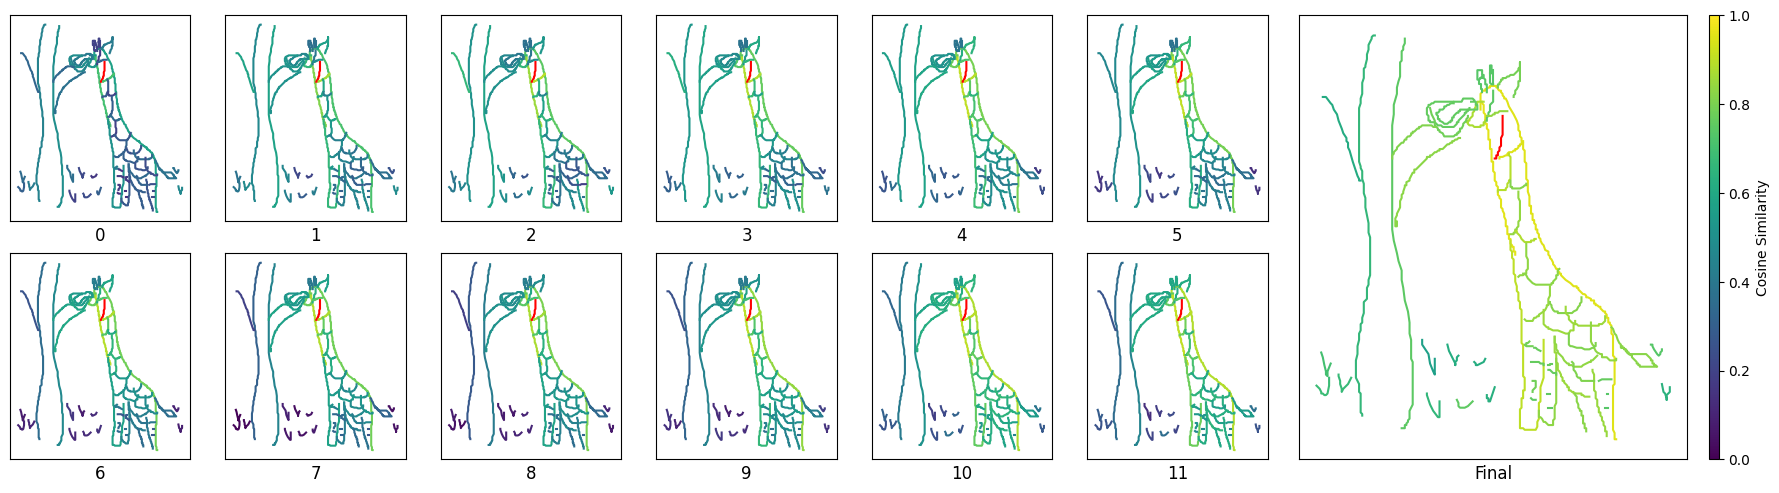

In [101]:
index = 0

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 14, 16, 14, 16).sum(dim = (2, 4)).reshape(-1, 196).to(device = device)

stroke_features = (stroke_sum.unsqueeze(-1) * clip_features[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 25
target = normed_stroke_features[:, target_index]

cos_sim = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 5))

gs = gridspec.GridSpec(2, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("clip_stroke_good.pdf", dpi = dpi)

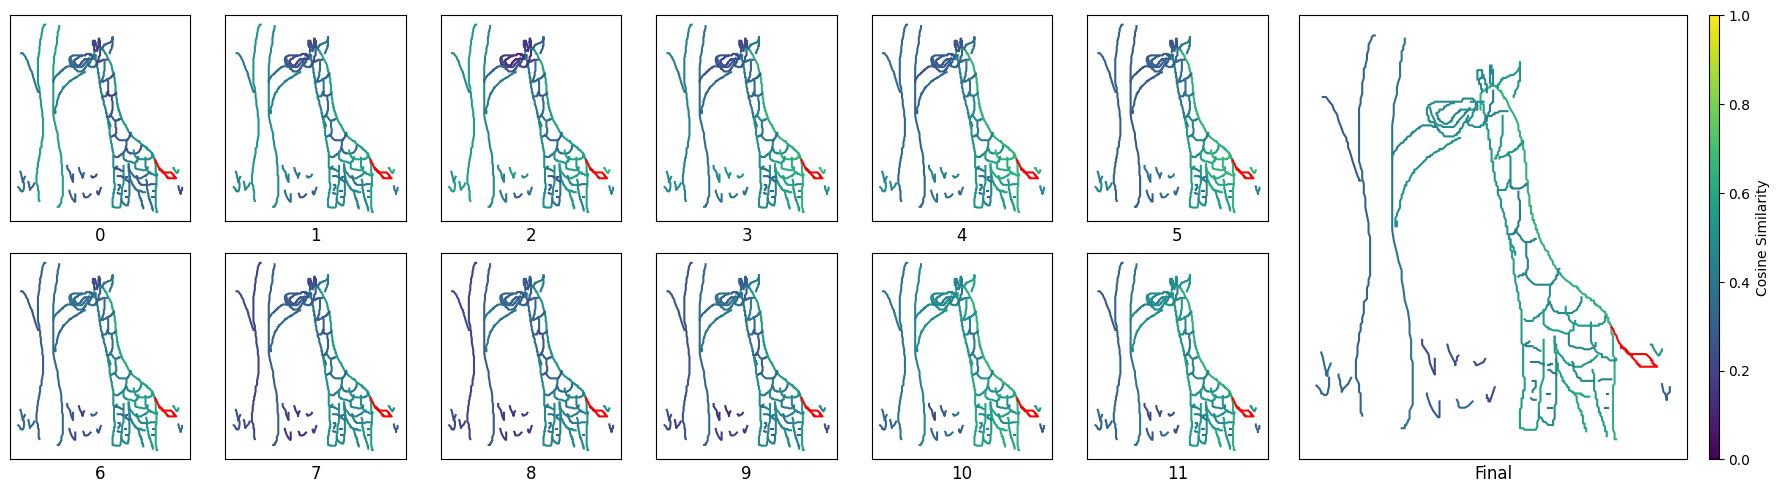

In [102]:
index = 0

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 14, 16, 14, 16).sum(dim = (2, 4)).reshape(-1, 196).to(device = device)

stroke_features = (stroke_sum.unsqueeze(-1) * clip_features[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 4
target = normed_stroke_features[:, target_index]

cos_sim = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 5))

gs = gridspec.GridSpec(2, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[layer, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("clip_stroke_bad.pdf", dpi = dpi)

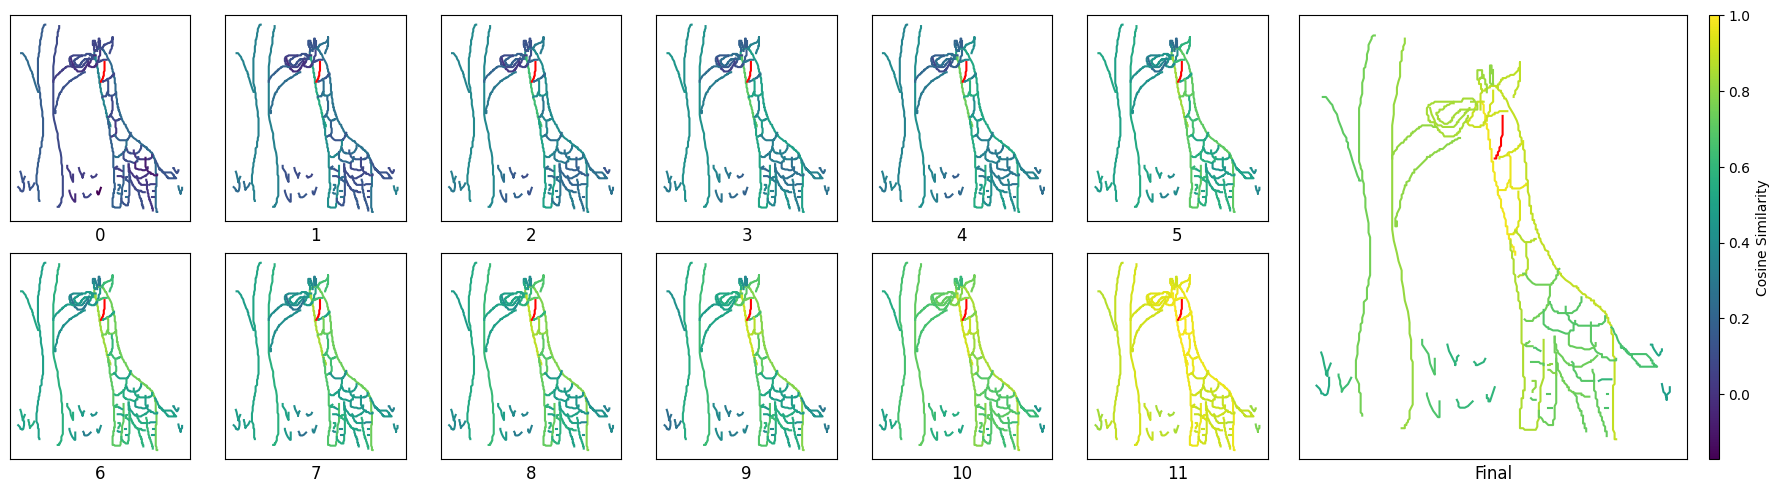

In [103]:
index = 0

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 16, 14, 16, 14).sum(dim = (2, 4)).reshape(-1, 256).to(device = device)

stroke_features = (stroke_sum.unsqueeze(-1) * dino_features_hierarchical[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 25
target = normed_stroke_features[:, target_index]

cos_sim = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 5))

gs = gridspec.GridSpec(2, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("dino_stroke_good.pdf", dpi = dpi)

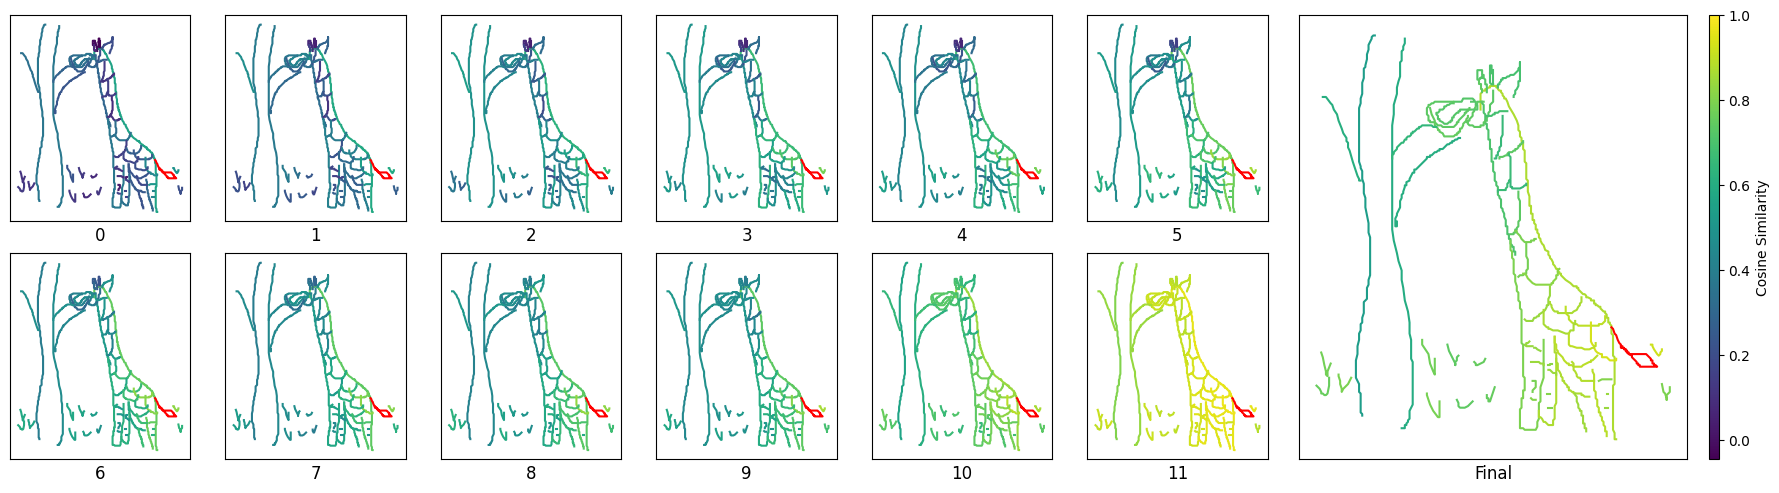

In [104]:
index = 0

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 16, 14, 16, 14).sum(dim = (2, 4)).reshape(-1, 256).to(device = device)

stroke_features = (stroke_sum.unsqueeze(-1) * dino_features_hierarchical[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 4
target = normed_stroke_features[:, target_index]

cos_sim = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

vmin, vmax = torch.min(cos_sim), torch.max(cos_sim)
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 5))

gs = gridspec.GridSpec(2, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("dino_stroke_bad.pdf", dpi = dpi)

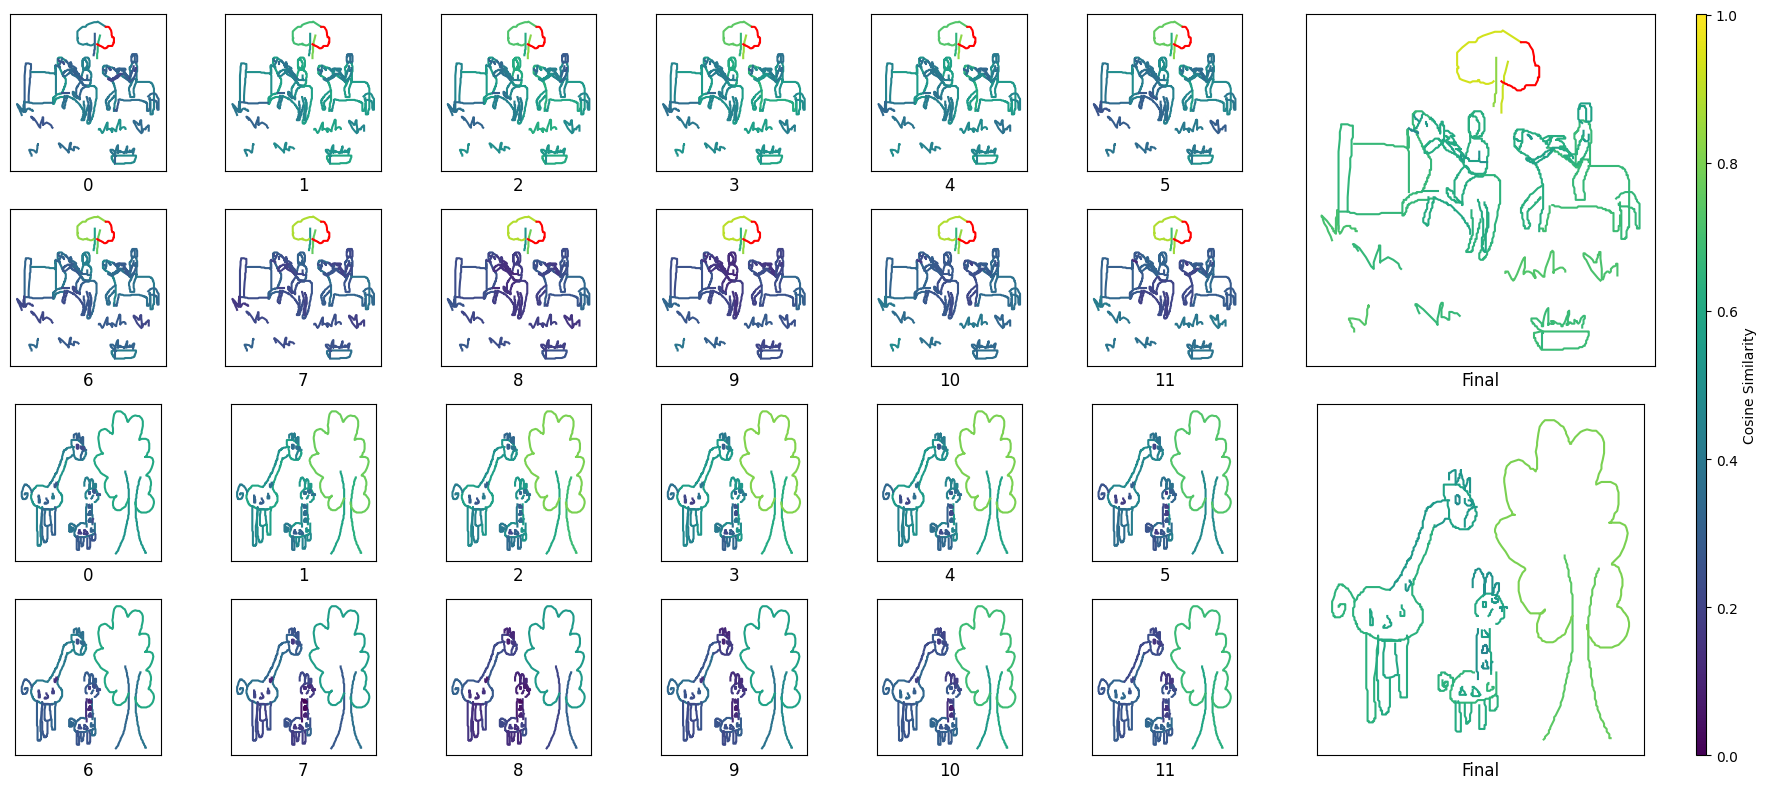

In [105]:
index = 1
index2 = 2

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 14, 16, 14, 16).sum(dim = (2, 4)).reshape(-1, 196).to(device = device)

stroke_features = (stroke_sum.unsqueeze(-1) * clip_features[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 62
target = normed_stroke_features[:, target_index]

cos_sim1 = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

stroke_sum2 = (~rasterized_strokes[index2]).reshape(-1, 14, 16, 14, 16).sum(dim = (2, 4)).reshape(-1, 196).to(device = device)

stroke_features2 = (stroke_sum2.unsqueeze(-1) * clip_features[index2].unsqueeze(1)).sum(2) / stroke_sum2.sum(-1).unsqueeze(-1).clamp(1)

normed_stroke_features2 = torch.nn.functional.normalize(stroke_features2, dim = -1)

cos_sim2 = (target.unsqueeze(1) * normed_stroke_features2).sum(-1)

vmin, vmax = min([torch.min(cos_sim1), torch.min(cos_sim2)]), max([torch.max(cos_sim1), torch.max(cos_sim2)])
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:2, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim1[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim1[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

indices = torch.where(vector_sketches[index2][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index2], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

ax_large = fig.add_subplot(gs[2:, 6])
for i, s in enumerate(strokes):
    ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim2[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row + 2, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim2[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("clip_stroke_inter.pdf", dpi = dpi)

torch.Size([13, 384]) torch.Size([13, 54, 384])
tensor(-0.0247, device='cuda:0', grad_fn=<MinBackward1>) tensor(1.0000, device='cuda:0', grad_fn=<MaxBackward1>)


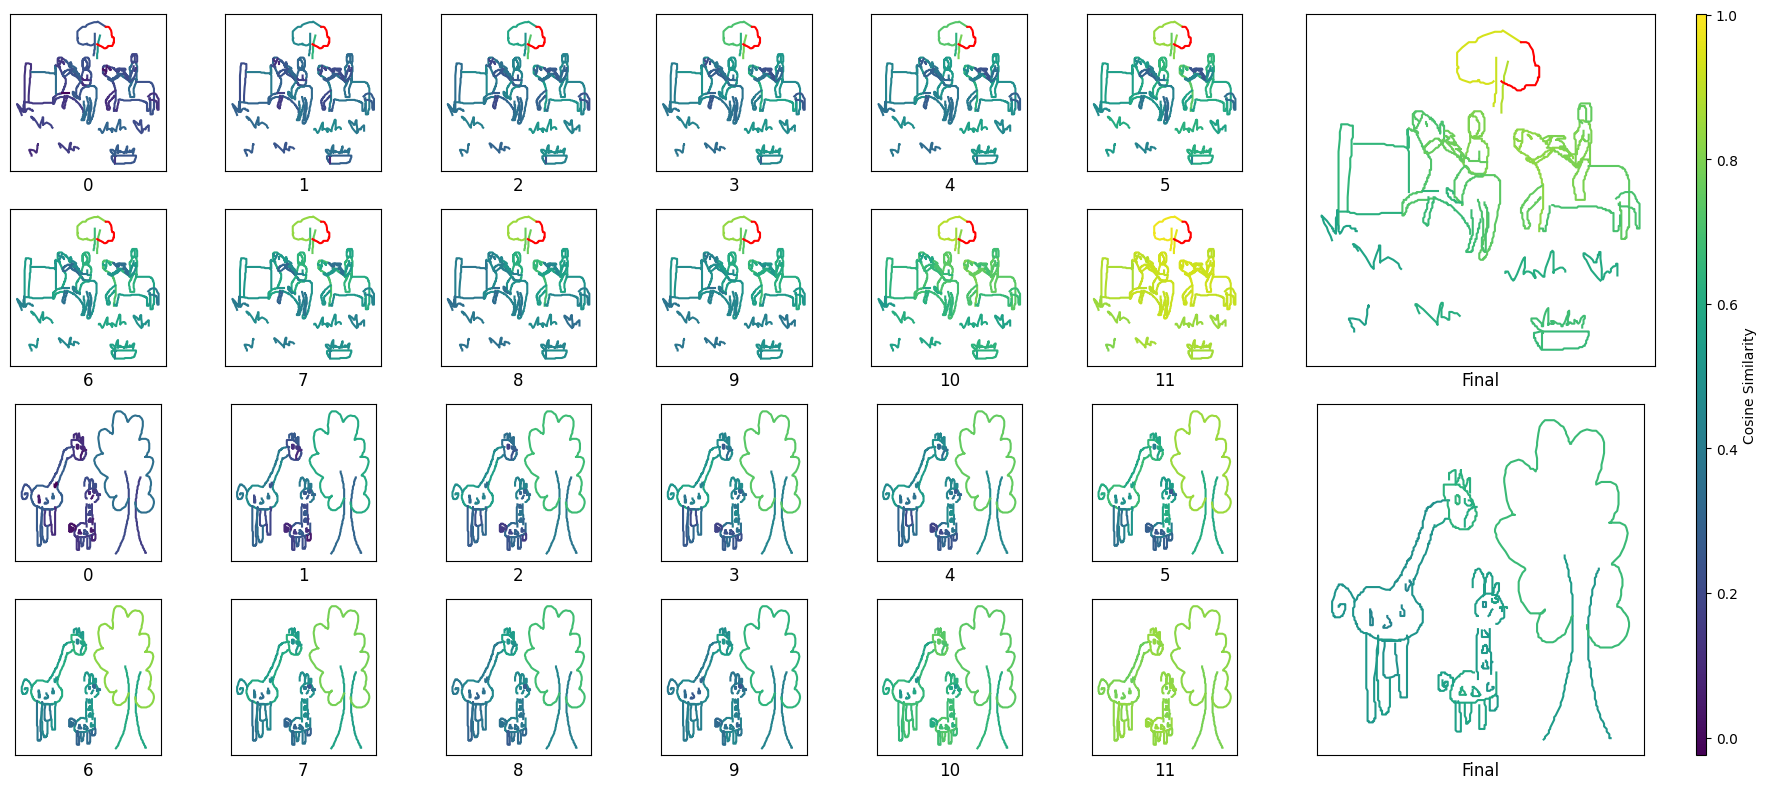

In [106]:
index = 1
index2 = 2

stroke_sum = (~rasterized_strokes[index]).reshape(-1, 16, 14, 16, 14).sum(dim = (2, 4)).reshape(-1, 256).to(device = device)

# print(stroke_sum.shape)
# print(dino_features_hierarchical.shape)

stroke_features = (stroke_sum.unsqueeze(-1) * dino_features_hierarchical[index].unsqueeze(1)).sum(2) / stroke_sum.sum(-1).unsqueeze(-1).clamp(1)

import matplotlib as mpl
cmap = mpl.colormaps['viridis']

normed_stroke_features = torch.nn.functional.normalize(stroke_features, dim = -1)

target_index = 62
target = normed_stroke_features[:, target_index]

cos_sim1 = (target.unsqueeze(1) * normed_stroke_features).sum(-1)

stroke_sum2 = (~rasterized_strokes[index2]).reshape(-1, 16, 14, 16, 14).sum(dim = (2, 4)).reshape(-1, 256).to(device = device)

stroke_features2 = (stroke_sum2.unsqueeze(-1) * dino_features_hierarchical[index2].unsqueeze(1)).sum(2) / stroke_sum2.sum(-1).unsqueeze(-1).clamp(1)

normed_stroke_features2 = torch.nn.functional.normalize(stroke_features2, dim = -1)

print(target.shape, normed_stroke_features2.shape)
cos_sim2 = (target.unsqueeze(1) * normed_stroke_features2).sum(-1)

vmin, vmax = min([torch.min(cos_sim1), torch.min(cos_sim2)]), max([torch.max(cos_sim1), torch.max(cos_sim2)])
print(vmin, vmax)
norm = Normalize(vmin=vmin, vmax=vmax)

indices = torch.where(vector_sketches[index][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

fig = plt.figure(figsize=(18, 8))

gs = gridspec.GridSpec(4, 8, width_ratios = [1, 1, 1, 1, 1, 1, 2, 0.05], height_ratios=[1, 1, 1, 1], figure = fig)

ax_large = fig.add_subplot(gs[:2, 6])
for i, s in enumerate(strokes):
    if i == target_index:
        ax_large.plot(s[:, 0], - s[:, 1], color = "red")
    else:
        ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim1[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            if i == target_index:
                ax.plot(s[:, 0], - s[:, 1], color = "red")
            else:
                ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim1[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

indices = torch.where(vector_sketches[index2][:, 2])[0] + 1
strokes = torch.tensor_split(vector_sketches[index2], indices.cpu())
strokes = [s for s in strokes if len(s) > 0]

ax_large = fig.add_subplot(gs[2:, 6])
for i, s in enumerate(strokes):
    ax_large.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim2[-1, i].detach().cpu())))
ax_large.set(aspect='equal')
ax_large.set_xlabel("Final", fontsize=12)
ax_large.set_xticks([])
ax_large.set_yticks([])

axes_subplots = []
for row in range(2):
    for col in range(6):
        ax = fig.add_subplot(gs[row + 2, col])
        ax.set_title("")
        layer = row * 6 + col
        for i, s in enumerate(strokes):
            ax.plot(s[:, 0], - s[:, 1], color = cmap(norm(cos_sim2[layer, i].detach().cpu())))
        ax.set_xlabel(str(layer), fontsize=12)
        ax.set(aspect='equal')
        ax.set_xticks([])
        ax.set_yticks([])

# Create a ScalarMappable for the colorbar
sm = ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])  # Required for the colorbar

cbar_ax = fig.add_subplot(gs[:, -1])
cbar = fig.colorbar(sm, cax=cbar_ax, orientation='vertical', fraction=0.1, pad=0.5)
cbar.set_label("Cosine Similarity")

plt.tight_layout()
plt.savefig("dino_stroke_inter.pdf", dpi = dpi)

In [107]:
# Real image:

# from PIL import Image

# image = Image.open("000000001739.jpg").resize((224, 224), Image.Resampling.LANCZOS)
# # image = Image.open("000000001501.jpg").resize((224, 224), Image.Resampling.LANCZOS)

# real_prepared_images = processor(images = image, do_rescale = True, return_tensors="pt")["pixel_values"]

# real_clip_features = torch.stack(clip(real_prepared_images.to(device = device), output_hidden_states = True)["hidden_states"], 1)[:, :, 1:]
# print(real_clip_features.shape)

# real_dino_features = dino.forward_features(real_prepared_images.to(device = device))['x_norm_patchtokens']
# print(real_dino_features.shape)

In [108]:
# #CLIP

# U, S, V = torch.svd_lowrank(real_clip_features, q = 3)

# print(U.shape)

# fig, axes = plt.subplots(1, 13, figsize=(10, 10))
# axes[0].imshow(image)
# axes[0].set_xlabel("Original", fontsize=12)
# axes[0].set_xticks([])
# axes[0].set_yticks([])
# for i in range(12):
#     visualize_feature(U[0, i].reshape(14, 14, 3), axes[i+1])
#     axes[i+1].set_xlabel(str(i), fontsize=12)
#     axes[i+1].set_xticks([])
#     axes[i+1].set_yticks([])

# plt.tight_layout()

In [109]:
# # Visualize dino features:
# U, S, V = torch.svd_lowrank(real_dino_features, q = 3)

# fig, axes = plt.subplots(1, 2, figsize=(10, 10))
# axes[0].imshow(image)
# axes[0].set_xlabel("Original", fontsize=12)
# axes[0].set_xticks([])
# axes[0].set_yticks([])

# visualize_feature(U[0].reshape(16, 16, 3), axes[1])
# axes[1].set_xlabel("DINO", fontsize=12)
# axes[1].set_xticks([])
# axes[1].set_yticks([])


# plt.tight_layout()

In [110]:
# # Visualize patch wise similarity:
# real_normed_features = torch.nn.functional.normalize(real_clip_features, dim = -1)


# # target_feature = normed_features.reshape(5, 13, 14, 14, 768)[0, :, 10, 10, :]
# real_target_feature = real_normed_features.reshape(1, 13, 14, 14, 768)[0, :, 9, 4, :]

# cos_sim = (real_target_feature.unsqueeze(1) * real_normed_features[0]).sum(-1)
# print(torch.min(cos_sim), torch.max(cos_sim))

# fig, axes = plt.subplots(2, 13, figsize=(15, 3))
# axes[0, 0].imshow(image)
# # axes[0, 0].set_xlabel("Original", fontsize=12)
# axes[0, 0].set_xticks([])
# axes[0, 0].set_yticks([])
# for i in range(12):
#     axes[0, i+1].imshow(cos_sim[i].detach().cpu().reshape(14, 14), vmin = -0.26, vmax = 1)
#     # axes[0, i+1].set_xlabel(str(i), fontsize=12)
#     axes[0, i+1].set_xticks([])
#     axes[0, i+1].set_yticks([])



# normed_features = torch.nn.functional.normalize(clip_features, dim = -1)

# target_feature = normed_features.reshape(6, 13, 14, 14, 768)[5, :, 7, 3, :]

# cos_sim = (target_feature.unsqueeze(1) * normed_features[5]).sum(-1)
# print(torch.min(cos_sim), torch.max(cos_sim))

# axes[1, 0].imshow(rasterized_sketches[5], cmap = "gray")
# axes[1, 0].set_xlabel("Original", fontsize=12)
# axes[1, 0].set_xticks([])
# axes[1, 0].set_yticks([])
# for i in range(12):
#     axes[1, i+1].imshow(cos_sim[i].detach().cpu().reshape(14, 14), vmin = -0.26, vmax = 1)
#     axes[1, i+1].set_xlabel(str(i), fontsize=12)
#     axes[1, i+1].set_xticks([])
#     axes[1, i+1].set_yticks([])

# plt.tight_layout()